In [1]:
import warnings
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [3]:
# Load data
xl = pd.ExcelFile('preliminary.xlsx')

# Read all sheets into a dictionary
data = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

res = []

for name in xl.sheet_names:
    # Extract the 'estimated_solar_generation' column as a list
    aux = data[name]['Est Total Solar'].tolist()
    res.append(aux)

# Flatten the list of lists
res = list(it.chain(*res))

print('original number of datapts =') #34 datapoints in total by month
print(len(res))

original number of datapts =
34


In [4]:
# Generate x values as enumeration of y values
x_data = np.arange(len(res))
y_data = np.array(res)

# Interpolation using cubic spline
interpolator = interp1d(x_data, y_data, kind='cubic')

x_interp = np.linspace(min(x_data), max(x_data), 68)
res_interpolated = interpolator(x_interp)

print('interpolated points =')
print(len(res_interpolated))

interpolated points =
68


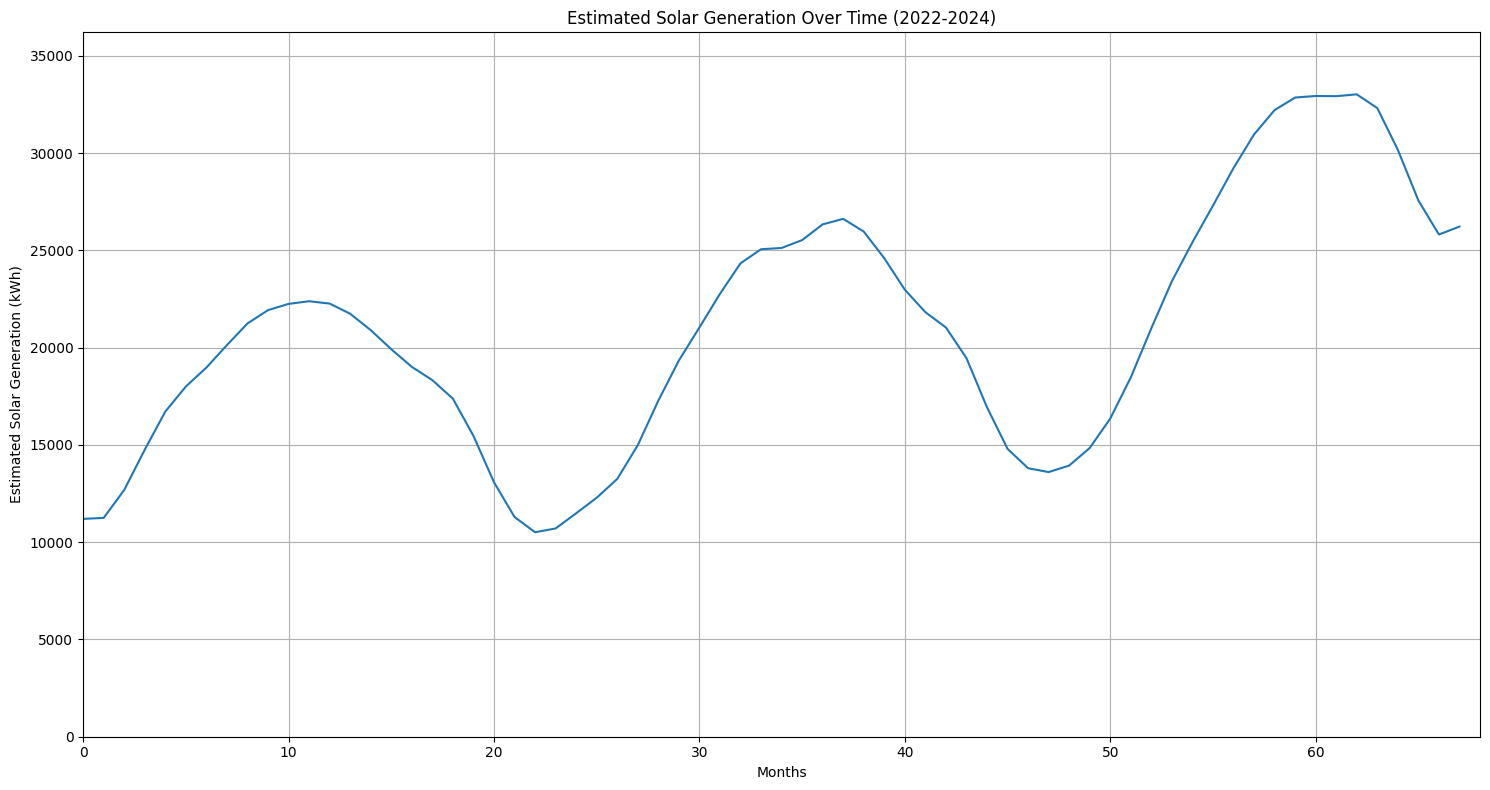

In [5]:
# Plot the interpolated data for verification and maintained seasonality
plt.figure(figsize=(15, 8))
plt.plot(res_interpolated)
plt.axis([0, len(res_interpolated), 0, max(res) * 1.1])
plt.xlabel('Months')
plt.ylabel('Estimated Solar Generation (kWh)')
plt.title('Estimated Solar Generation Over Time (2022-2024)')

plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Define the sinusoidal exponential midline function
def sinusoidal_exponential(x, A, B, C, D, E, F):
    return A * np.sin(B * x + C) + D * np.exp(E * x) + F

# Define the sinusoidal logistic function
def sinusoidal_logistic(x, A, B, C, D, E, F, G):
    return A * np.sin(B * x + C) + D / (1 + np.exp(-E * (x - F))) + G

In [7]:
x = np.arange(68)
y = np.array(res_interpolated)

# Initial guess for the parameters (you can adjust these)
initial_guess = [1, 0.1, 0, 1, 0.01, 0]

# Fit the data
params, params_covariance = curve_fit(sinusoidal_exponential, x, y, p0=initial_guess)

# Extract fitted parameters
A, B, C, D, E, F = params
print(f"Fitted Parameters:\nA={A}, B={B}, C={C}, D={D}, E={E}, F={F}")

# Compute the predicted values
y_pred = sinusoidal_exponential(x, A, B, C, D, E, F)

# Calculate R^2
ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 = {r_squared}")

Fitted Parameters:
A=-6910.826683361488, B=-0.2573750853146038, C=-5.098233825898717, D=1589.6607755722025, E=0.03233575457771401, F=14723.759130792267
R^2 = 0.9802710346950512


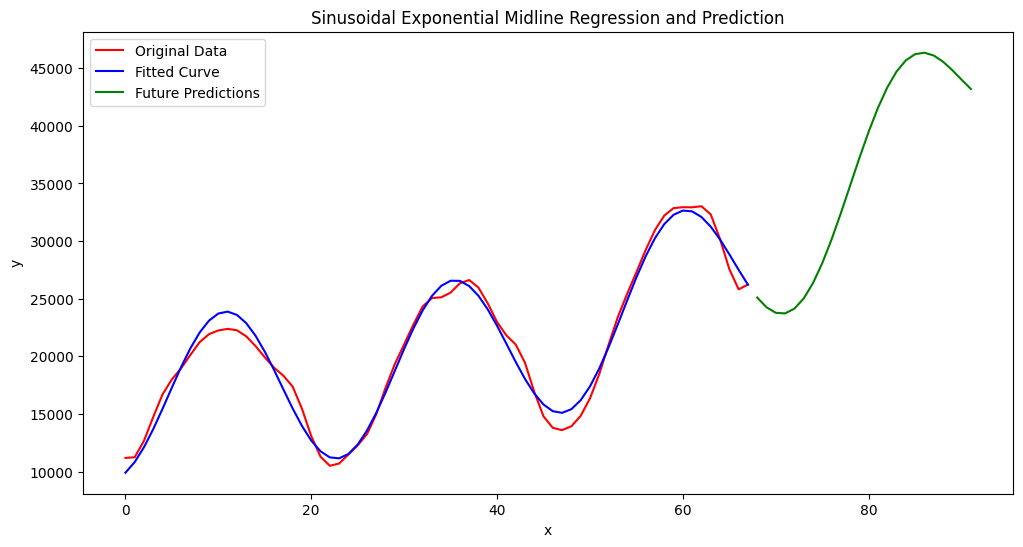

Prediction 1: 25102.7092
Prediction 2: 24260.5292
Prediction 3: 23780.6115
Prediction 4: 23727.1245
Prediction 5: 24137.2139
Prediction 6: 25018.5918
Prediction 7: 26349.0641
Prediction 8: 28078.0306
Prediction 9: 30129.8572
Prediction 10: 32408.8981
Prediction 11: 34805.8380
Prediction 12: 37204.9366
Prediction 13: 39491.6970
Prediction 14: 41560.4538
Prediction 15: 43321.3816
Prediction 16: 44706.4603
Prediction 17: 45674.0070
Prediction 18: 46211.4731
Prediction 19: 46336.3250
Prediction 20: 46094.9483
Prediction 21: 45559.6498
Prediction 22: 44823.9523
Prediction 23: 43996.4952
Prediction 24: 43193.9404
RMSE = 889.7744
NRMSE = 0.0395
MAE = 748.6832


In [8]:
# Generate predictions for the next 24 datapoints
x_future = np.arange(68, 68 + 24)
y_future = sinusoidal_exponential(x_future, *params)

# Plot the original data, fitted curve, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Original Data', color='red', linestyle='-')
plt.plot(x, sinusoidal_exponential(x, *params), label='Fitted Curve', color='blue', linestyle='-')
plt.plot(x_future, y_future, label='Future Predictions', color='green', linestyle='-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sinusoidal Exponential Midline Regression and Prediction')
plt.legend()
plt.show()

# Print future predictions
for i, pred in enumerate(y_future, start=1):
    print(f"Prediction {i}: {pred:.4f}")

# Calculate RMSE, NRMSE, and MAE
rmse = root_mean_squared_error(y, y_pred)
nrmse = rmse / (np.max(y) - np.min(y))
mae = mean_absolute_error(y, y_pred)

print(f"RMSE = {rmse:.4f}")
print(f"NRMSE = {nrmse:.4f}")
print(f"MAE = {mae:.4f}")

In [9]:
# Initial guess for the parameters (adjust based on expected behavior)
initial_guess = [np.ptp(y) / 2, 0.1, 0, max(y), 0.01, 34, np.mean(y)]

# Fit the data
params, params_covariance = curve_fit(sinusoidal_logistic, x, y, p0=initial_guess)

# Extract fitted parameters
A, B, C, D, E, F, G = params
print(f"Fitted Parameters:\nA={A}, B={B}, C={C}, D={D}, E={E}, F={F}, G={G}")

# Compute the predicted values
y_pred = sinusoidal_logistic(x, A, B, C, D, E, F, G)

# Calculate R^2
ss_res = np.sum((y - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 = {r_squared}")

Fitted Parameters:
A=12540.229617220128, B=0.09086596306439497, C=0.5463812168323829, D=24742.640638767338, E=0.6745598834127412, F=28.945970890754893, G=6940.119596138692
R^2 = 0.7196629618127965


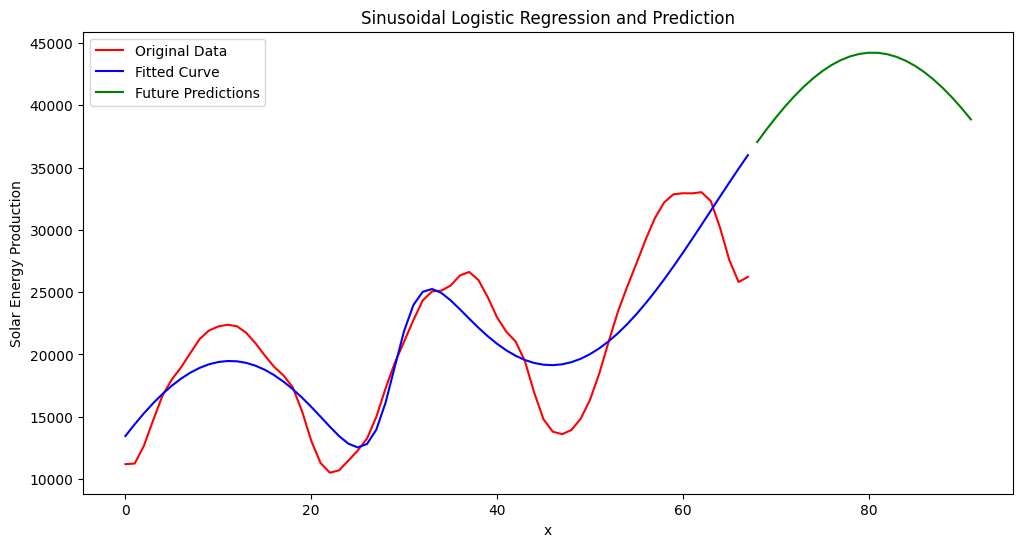

Prediction 1: 37047.7425
Prediction 2: 38054.1267
Prediction 3: 39007.9411
Prediction 4: 39901.3159
Prediction 5: 40726.8799
Prediction 6: 41477.8213
Prediction 7: 42147.9442
Prediction 8: 42731.7195
Prediction 9: 43224.3304
Prediction 10: 43621.7125
Prediction 11: 43920.5870
Prediction 12: 44118.4878
Prediction 13: 44213.7822
Prediction 14: 44205.6838
Prediction 15: 44094.2594
Prediction 16: 43880.4285
Prediction 17: 43565.9553
Prediction 18: 43153.4345
Prediction 19: 42646.2699
Prediction 20: 42048.6459
Prediction 21: 41365.4936
Prediction 22: 40602.4496
Prediction 23: 39765.8098
Prediction 24: 38862.4771
RMSE = 3354.0380
NRMSE = 0.1490
MAE = 2628.7147


In [11]:
# Generate predictions for the next 24 datapoints
x_future = np.arange(68, 68 + 24)
y_future = sinusoidal_logistic(x_future, *params)

# Plot the original data, fitted curve, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Original Data', color='red', linestyle='-')
plt.plot(x, sinusoidal_logistic(x, *params), label='Fitted Curve', color='blue', linestyle='-')
plt.plot(x_future, y_future, label='Future Predictions', color='green', linestyle='-')
plt.xlabel('x')
plt.ylabel('Solar Energy Production')
plt.title('Sinusoidal Logistic Regression and Prediction')
plt.legend()
plt.show()

# Print future predictions
for i, pred in enumerate(y_future, start=1):
    print(f"Prediction {i}: {pred:.4f}")

# Calculate RMSE, NRMSE, and MAE
rmse = root_mean_squared_error(y, y_pred)
nrmse = rmse / (np.max(y) - np.min(y))
mae = mean_absolute_error(y, y_pred)

print(f"RMSE = {rmse:.4f}")
print(f"NRMSE = {nrmse:.4f}")
print(f"MAE = {mae:.4f}")